Here, I train a best point-estimate readout of the stimulus orientation.

I use PyTorch throughout the implementation here instead of straight up NumPy.

In [11]:
import datajoint as dj
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.init import normal, constant
from torch import nn
from matplotlib import pyplot as plt
from attorch.train import early_stopping
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

%matplotlib inline

from numpy.linalg import inv

from v1_likelihood.train import CVSet, KernelRegression, LinearRegression, schema

In [8]:
KernelRegression().populate(limit=1)

2100it [00:50, 41.63it/s]


In [6]:
LinearRegression()

bin_config_id id,csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,lr_weights learned weights,lr_trainset_score score on trainset,lr_testset_score score on testset
9c9248d6b67fe1d8348bc51605658447,0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,=BLOB=,8.80198,10.3265
9c9248d6b67fe1d8348bc51605658447,0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.04,35,57eeec0a6974ecb4e9fcf68fab052f7b,=BLOB=,4.12118,4.83828
9c9248d6b67fe1d8348bc51605658447,0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.32,35,57eeec0a6974ecb4e9fcf68fab052f7b,=BLOB=,2.47696,2.92996
9c9248d6b67fe1d8348bc51605658447,0732f2b73f4900ee4fa81f8853b48e460a42ee14,0.02,35,57eeec0a6974ecb4e9fcf68fab052f7b,=BLOB=,3.79281,4.52524
9c9248d6b67fe1d8348bc51605658447,0732f2b73f4900ee4fa81f8853b48e460a42ee14,0.16,35,57eeec0a6974ecb4e9fcf68fab052f7b,=BLOB=,2.12098,2.67761
9c9248d6b67fe1d8348bc51605658447,0732f2b73f4900ee4fa81f8853b48e460a42ee14,1,35,57eeec0a6974ecb4e9fcf68fab052f7b,=BLOB=,1.36246,1.66398
9c9248d6b67fe1d8348bc51605658447,0821d6c856639dcb7bb67b1dc8d0f2339b60e27f,0.01,35,57eeec0a6974ecb4e9fcf68fab052f7b,=BLOB=,6.79577,8.38956


In [120]:
keys = CVSet().fetch('KEY')

In [121]:
keys[343]

{'csc_hash': 'b047337460082b62b44a8bc4ccfb4c400b6c9e95',
 'cv_config_id': '57eeec0a6974ecb4e9fcf68fab052f7b',
 'cv_seed': 35,
 'dataset_contrast': '0.1'}

## Get the dataset

In [122]:
train_set, test_set = (CVSet() & keys[344]).fetch_datasets()

Pre-process

In [123]:
train_counts = np.concatenate(train_set['counts'], 1).T
train_ori = train_set['orientation'] - 270
test_counts = np.concatenate(test_set['counts'], 1).T
test_ori = test_set['orientation'] - 270

Place them on CUDA

In [124]:
train_counts = torch.Tensor(train_counts).cuda()
train_ori = torch.Tensor(train_ori).cuda()
test_counts = torch.Tensor(test_counts).cuda()
test_ori = torch.Tensor(test_ori).cuda()

## Simple linear regression

In [114]:
def extend_ones(x):
    return torch.cat((x, x.new(x.size(0), 1).fill_(1)), 1)

tc = extend_ones(train_counts)
lam = 0.0001
reg = torch.eye(tc.size(1)) * lam
reg = reg.type(tc.type())
w = torch.inverse(tc.t() @ tc + reg) @ tc.t() @ train_ori


t_hat = extend_ones(test_counts) @ w
rmse = np.sqrt((t_hat - test_ori).pow(2).mean())

Text(0.5,1,'2.7683508419499065')

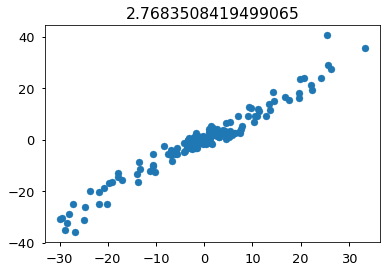

In [115]:
plt.scatter(t_hat, test_ori)
plt.title(rmse)

## Now implement kernel regression

In [125]:
mu = train_counts.mean(0, keepdim=True)
tc = train_counts - mu
vc = test_counts - mu

In [126]:
def kernel(x, y, sigma):
    return torch.exp(-(x.unsqueeze(1) - y.unsqueeze(0)).pow(2).sum(-1) / 2 / sigma**2)

In [129]:
lam = 0.01
sigma = 300
K = kernel(tc, tc, sigma)
reg = torch.eye(K.size(0)) * lam
reg = reg.type(K.type())
alpha = torch.inverse(K + reg) @ train_ori
t_hat = kernel(vc, tc, sigma) @ alpha
rmse = np.sqrt((t_hat - test_ori).pow(2).mean())

In [130]:
class KernelReg:
    def __init__(self, lam=0.01, sigma=300):
        self.sigma = sigma
        self.lam = lam
        self.alpha = None
        self.mu = None
        self.x_train = None
        
    def fit(self, x, y):
        self.mu = x.mean(0, keepdim=True)
        xc = x - self.mu
        self.x_train = xc
        K = kernel(xc, xc, self.sigma)
        reg = torch.eye(K.size(0)) * self.lam
        reg = reg.type(K.type())
        self.alpha = torch.inverse(K + reg) @ y
        
    def __call__(self, x):
        return kernel(x-self.mu, self.x_train, self.sigma) @ self.alpha
        
    def rmse(self, x, y):
        yhat = self(x)
        return np.sqrt((yhat - y).pow(2).mean())

In [148]:
from itertools import product
from tqdm import tqdm

In [167]:
kr = KernelReg()
lams = 10.0**np.arange(-3, 4)
sigmas = np.logspace(-1, 3, 300)
rmse = np.empty((len(lams), len(sigmas)))
for (i,l), (j,s) in tqdm(product(enumerate(lams), enumerate(sigmas))):
    kr.sigma = s
    kr.lam = l
    kr.fit(train_counts, train_ori)
    rmse[i, j] = kr.rmse(test_counts, test_ori)
    

2100it [00:36, 57.25it/s]


In [175]:
lmin_pos, smin_pos = np.where(rmse == rmse.min())
lam = lams[lmin_pos[0]]
sigma = sigmas[smin_pos[0]]

kr.lam = lam
kr.sigma = sigma
kr.fit(train_counts, train_ori)
train_score = kr.rmse(train_counts, train_ori)
test_score = kr.rmse(test_counts, test_ori)


In [183]:
kr.alpha.cpu().numpy()

(628,)

In [178]:
train_score

0.6723321424045647

In [179]:
test_score

1.7303774704119483

In [ ]:
np.logra

In [144]:
rmse

array([[12.44341134, 12.44341134, 12.44341134,  2.38439889,  2.65333649],
       [12.44341134, 12.44341134, 12.44341134,  2.47083619,  3.4698644 ],
       [12.44341134, 12.44341134, 12.44341134,  3.18407885,  6.83740888],
       [12.44341134, 12.44341134, 12.44341134,  5.87154043, 11.27606911]])

In [138]:
product?

In [131]:
kr = KernelReg(sigma=300, lam=0.01)

In [132]:
kr.fit(train_counts, train_ori)

In [133]:
yhat = kr(test_counts)

In [136]:
kr.rmse(test_counts, test_ori)

1.783905125096643

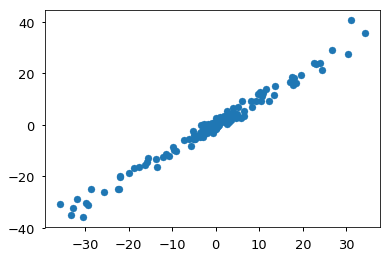

In [134]:
plt.scatter(yhat, test_ori)

In [ ]:
kernel_reg()

Text(0.5,1,'1.783905125096643')

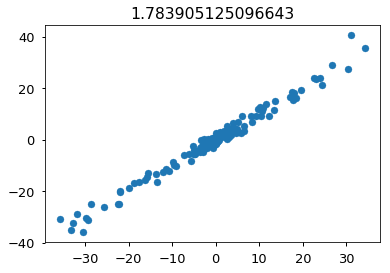

In [128]:
plt.scatter(t_hat, test_ori)
plt.title(rmse)

In [102]:
tc.size()

torch.Size([628, 96])

In [139]:
%%timeit
lam = 0.01
K = kernel(tc, tc)
alpha = inv(K + lam * np.eye(K.shape[0])) @ train_ori
y_t = kernel(vc, tc)@alpha

298 ms ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


PyTorch version

In [160]:
def kernel_torch(x, y, sigma):
    return torch.exp(-(x.unsqueeze(1) - y.unsqueeze(0)).pow(2)).sum(dim=-1) /2 / sigma**2

class KernelRegression:
    def __init__(self, lam=0.01, sigma=373):
        self.alpha = None
        self.xt = None
        self.mu = None
        self.lam = lam
        self.sigma = sigma
    
    def fit(self, x, y):
        self.mu = x.mean(0, keepdim=True)
        x = x - self.mu
        self.xt = x
        K = kernel_torch(tc, tc, sigma=self.sigma)
        D = self.lam * torch.eye(K.size(0)).cuda()
        alpha = torch.inverse(K + D) @ tori
        self.alpha = alpha
        
    def __call__(self, x):
        return kernel_torch(x - self.mu, self.xt, sigma=self.sigma) @ self.alpha

        
        

In [169]:
kr = KernelRegression(sigma=0, lam=0)
kr.fit(train_x, tori)

RuntimeError: invalid argument 3: divide by zero at /pytorch/torch/lib/THC/generic/THCTensorMathPairwise.cu:88

In [170]:
plt.scatter(kr(valid_x).cpu().numpy(), valid_ori)

RuntimeError: invalid argument 3: divide by zero at /pytorch/torch/lib/THC/generic/THCTensorMathPairwise.cu:88

In [143]:
mu = train_x.mean(0, keepdim=True)
tc = train_x - mu
vc = valid_x - mu
tori = torch.from_numpy(train_ori.astype('float32')).cuda()

In [120]:
lam = 3
K = kernel_torch(tc, tc)
D = lam * torch.eye(K.size(0)).cuda()
alpha = torch.inverse(K + D) @ tori
yt = kernel_torch(vc, tc) @ alpha

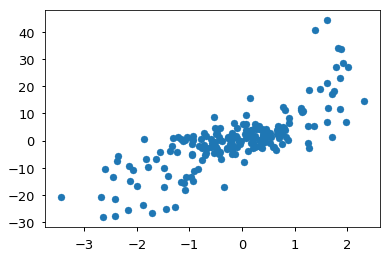

In [121]:
plt.scatter(yt.cpu().numpy(), valid_ori)

In [122]:
from tqdm import tqdm

In [127]:
sigma = np.logspace(-2, 3, 300)
kr = KernelRegression()
v = []
for s in tqdm(sigma):
    lam = 0.01
    kr.sigma = s
    kr.fit(train_x, tori)
    yt = kr(valid_x)
    v.append(np.sqrt(np.mean((yt.cpu().numpy() - valid_ori)**2)))
    
v = np.array(v)

100%|██████████| 300/300 [00:06<00:00, 46.20it/s]


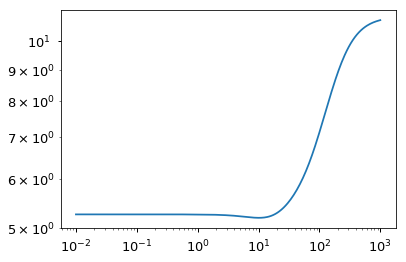

In [129]:
#plt.plot(sigma, v)
plt.loglog(sigma, v)

In [130]:
sigma[np.argmin(v)]

10.233717986325193

In [114]:
plt.scatter(y_t, valid_ori)

NameError: name 'y_t' is not defined

In [112]:
np.sqrt(np.mean((yt.cpu().numpy() - valid_ori)**2))

10.12060469333046

In [142]:
np.sqrt(np.mean((t_hat - valid_ori)**2))

2.241819870052254

## Fit NN

In [163]:
n_ch = train_dataset.data_tensor.size(1)
net = Net(n_channel=n_ch, n_output=1, n_hidden=[], std=0.0001, dropout=0.5)
net.cuda()
loss = nn.CrossEntropyLoss().cuda()

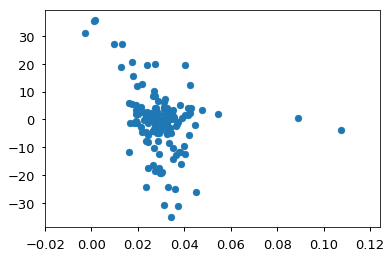

In [164]:
yv = net(valid_x).data.cpu().numpy()
plt.scatter(yv, valid_ori)

2.1325656379388085


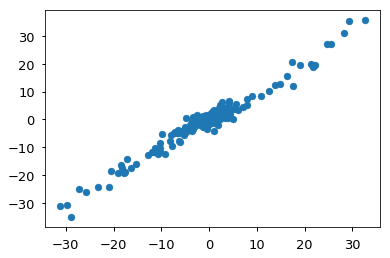

In [171]:
net.eval()
y = net(valid_x)
yd = y.data.cpu().numpy()


plt.subplot(111)
t_hat = yd #valid_t.data.cpu().numpy()
plt.scatter(t_hat, valid_ori)


print(np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta)


In [170]:
net.std = 1e-4
net.initialize()

alpha = 1e-3 #3e-2 #7e-3 #1e-3


#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.3)
learning_rates = 1e-6 * 3.0**(-np.arange(3))

for lr in learning_rates:
    print('\n\n\n\n LEARNING RATE: {}'.format(lr))
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    for epoch, valid_score in early_stopping(net, objective, interval=20, start=100, patience=20, max_iter=300000, maximize=False):
        data_loader = DataLoader(train_dataset, shuffle=True, batch_size=256)
        for x_, t_ in data_loader:
            x, t = Variable(x_).cuda(), Variable(t_).cuda()
            net.train()
            optimizer.zero_grad()
            y = net(x)
            loss = (y - t).pow(2).mean()
            score = loss + net.regularizer() * alpha
            score.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print('Score: {}'.format(score.data.cpu().numpy()[0]))
        #scheduler.step()





 LEARNING RATE: 1e-06
Score: 89.03565979003906
Score: 90.50482940673828
[120|00/20] ---> 8.6648588180542
Score: 69.51829528808594
Score: 45.256107330322266
[140|00/20] ---> 7.050090312957764
Score: 60.16167449951172
Score: 41.19031524658203
[160|00/20] ---> 5.8310956954956055
Score: 20.58528709411621
Score: 21.6724853515625
[180|00/20] ---> 4.952648639678955
Score: 11.1218843460083
Score: 18.983932495117188
[200|00/20] ---> 4.339114189147949
Score: 17.253772735595703
Score: 10.677140235900879
[220|00/20] ---> 3.9117255210876465
Score: 13.281632423400879
Score: 16.540775299072266
[240|00/20] ---> 3.5889956951141357
Score: 13.265745162963867
Score: 12.243559837341309
[260|00/20] ---> 3.378286600112915
Score: 7.820139408111572
Score: 16.25782585144043
[280|00/20] ---> 3.225663661956787
Score: 12.27928638458252
Score: 9.146976470947266
[300|00/20] ---> 3.1258797645568848
Score: 12.685098648071289
Score: 7.168489933013916
[320|00/20] ---> 3.049675464630127
Score: 5.747095108032227
Score

Score: 4.2058329582214355
Score: 5.1568474769592285
[2020|00/20] ---> 2.309619188308716
Score: 6.431237697601318
Score: 4.114184379577637
[2040|00/20] ---> 2.306811571121216
Score: 4.800900936126709
Score: 5.1033854484558105
[2060|00/20] ---> 2.3051652908325195
Score: 5.821104049682617
Score: 4.611342906951904
[2080|00/20] ---> 2.3014798164367676
Score: 7.144637584686279
Score: 4.629720211029053
[2100|00/20] ---> 2.2989108562469482
Score: 4.438451290130615
Score: 6.031625747680664
[2120|00/20] ---> 2.2982866764068604
Score: 4.2530670166015625
Score: 7.152066230773926
[2140|01/20] -/-> 2.3009088039398193
Score: 4.121698379516602
Score: 4.877193450927734
[2160|01/20] ---> 2.2920374870300293
Score: 6.890336513519287
Score: 4.287968158721924
[2180|00/20] ---> 2.291426420211792
Score: 4.387718677520752
Score: 6.992166042327881
[2200|00/20] ---> 2.2881405353546143
Score: 4.439408302307129
Score: 5.383689880371094
[2220|00/20] ---> 2.284698247909546
Score: 4.629483222961426
Score: 4.395981311

Score: 5.792129993438721
Score: 4.3248491287231445
[3920|01/20] -/-> 2.18251371383667
Score: 3.6547887325286865
Score: 5.81541109085083
[3940|01/20] ---> 2.1789052486419678
Score: 4.512282371520996
Score: 4.143835067749023
[3960|00/20] ---> 2.178145170211792
Score: 4.509587287902832
Score: 3.928530216217041
[3980|00/20] ---> 2.177001714706421
Score: 3.548327684402466
Score: 4.73477840423584
[4000|00/20] ---> 2.1767396926879883
Score: 4.276872634887695
Score: 5.406247138977051
[4020|01/20] -/-> 2.1842150688171387
Score: 3.791215181350708
Score: 4.175145626068115
[4040|02/20] -/-> 2.1780645847320557
Score: 5.431271553039551
Score: 4.805324077606201
[4060|02/20] ---> 2.1762895584106445
Score: 3.0848326683044434
Score: 5.772311210632324
[4080|01/20] -/-> 2.180201530456543
Score: 2.988067150115967
Score: 5.537379264831543
[4100|02/20] -/-> 2.182953119277954
Score: 4.554473400115967
Score: 4.623468399047852
[4120|02/20] ---> 2.1745972633361816
Score: 6.756757736206055
Score: 5.01635122299194

Score: 3.603663921356201
Score: 2.69057559967041
[5820|03/20] -/-> 2.1424717903137207
Score: 5.118040084838867
Score: 5.014619827270508
[5840|03/20] ---> 2.141702651977539
Score: 4.874146461486816
Score: 3.972034215927124
[5860|01/20] -/-> 2.1419291496276855
Score: 4.245365619659424
Score: 4.484832763671875
[5880|02/20] -/-> 2.1498279571533203
Score: 2.8099989891052246
Score: 4.480881214141846
[5900|02/20] ---> 2.141308307647705
Score: 4.597332000732422
Score: 4.122804164886475
[5920|01/20] -/-> 2.1414482593536377
Score: 4.257862091064453
Score: 6.761531829833984
[5940|02/20] -/-> 2.149635076522827
Score: 4.038855075836182
Score: 6.3056254386901855
[5960|03/20] -/-> 2.1424214839935303
Score: 4.052382469177246
Score: 4.937600612640381
[5980|03/20] ---> 2.1408510208129883
Score: 4.536925315856934
Score: 3.92817759513855
[6000|00/20] ---> 2.140791893005371
Score: 3.8358333110809326
Score: 3.913557767868042
[6020|00/20] ---> 2.1407182216644287
Score: 4.460336208343506
Score: 3.571505308151

Score: 4.269764423370361
Score: 4.152031421661377
[7720|06/20] -/-> 2.1335973739624023
Score: 4.772833347320557
Score: 4.275867462158203
[7740|07/20] -/-> 2.1334941387176514
Score: 3.929966688156128
Score: 3.5146498680114746
[7760|08/20] -/-> 2.1331169605255127
Score: 6.111900806427002
Score: 4.777185440063477
[7780|09/20] -/-> 2.1338348388671875
Score: 4.626745700836182
Score: 3.5679736137390137
[7800|10/20] -/-> 2.137066125869751
Score: 4.455842971801758
Score: 4.200881481170654
[7820|11/20] -/-> 2.133364677429199
Score: 4.3316521644592285
Score: 4.143239974975586
[7840|12/20] -/-> 2.1381213665008545
Score: 5.349618434906006
Score: 4.905980587005615
[7860|12/20] ---> 2.1326382160186768
Score: 4.608816623687744
Score: 4.055396556854248
[7880|01/20] -/-> 2.133043050765991
Score: 4.014856338500977
Score: 5.037176132202148
[7900|02/20] -/-> 2.1333062648773193
Score: 4.964505195617676
Score: 4.660235404968262
[7920|03/20] -/-> 2.1329128742218018
Score: 4.936802387237549
Score: 3.852244377

In [104]:
net.initialize()

In [61]:
t_


 -1.2110
 -7.3630
  0.2140
 -1.6730
 21.3150
 -2.3010
 -4.3950
  3.6250
-10.1410
 -1.0890
 -5.2380
 18.9020
 -2.1420
 -7.3980
 -0.3300
  9.2180
-17.3650
  0.4900
  0.7450
  1.8480
  0.4080
  3.2630
-12.3020
  1.2860
  3.5330
 -5.7670
 -1.5180
  3.0490
-19.8100
 -0.5180
 11.7990
 23.0120
 -0.9580
 15.1160
 -4.3080
  8.8040
 -2.1340
 -0.4570
  3.2500
-22.9430
  1.1130
 -5.4440
  1.4910
 -1.9800
  9.3610
 -2.0550
  0.4420
 -4.4430
  2.2860
 -1.8670
-13.7800
 16.0400
 12.0090
-22.1010
  2.4950
 -0.6860
  5.1530
 -0.6060
  1.6600
 -2.0190
 -0.7870
 -3.6930
  2.3670
-31.0030
  0.2070
 11.6720
 -0.4350
 20.5100
  2.1540
 16.2560
 -0.8210
 -5.4410
  1.5390
 11.6030
 10.6460
 -2.9770
  9.3090
  2.4420
-20.1680
 13.4270
 12.3780
  0.6750
 35.6190
-11.4610
 -9.8890
 -0.5510
  0.0820
  2.1060
 -2.3410
  0.2640
  4.0190
-18.8510
-24.2240
  3.9320
 -5.3770
  0.0450
  1.2180
 -5.9920
  2.1990
-10.7660
  4.0530
-11.6350
-25.0490
 -4.0080
  3.3180
 -1.5120
-14.2840
 -0.4850
 -2.0960
-19.7830
-18.8710


In [56]:
t

Variable containing:
 -1.2110
 -7.3630
  0.2140
 -1.6730
 21.3150
 -2.3010
 -4.3950
  3.6250
-10.1410
 -1.0890
 -5.2380
 18.9020
 -2.1420
 -7.3980
 -0.3300
  9.2180
-17.3650
  0.4900
  0.7450
  1.8480
  0.4080
  3.2630
-12.3020
  1.2860
  3.5330
 -5.7670
 -1.5180
  3.0490
-19.8100
 -0.5180
 11.7990
 23.0120
 -0.9580
 15.1160
 -4.3080
  8.8040
 -2.1340
 -0.4570
  3.2500
-22.9430
  1.1130
 -5.4440
  1.4910
 -1.9800
  9.3610
 -2.0550
  0.4420
 -4.4430
  2.2860
 -1.8670
-13.7800
 16.0400
 12.0090
-22.1010
  2.4950
 -0.6860
  5.1530
 -0.6060
  1.6600
 -2.0190
 -0.7870
 -3.6930
  2.3670
-31.0030
  0.2070
 11.6720
 -0.4350
 20.5100
  2.1540
 16.2560
 -0.8210
 -5.4410
  1.5390
 11.6030
 10.6460
 -2.9770
  9.3090
  2.4420
-20.1680
 13.4270
 12.3780
  0.6750
 35.6190
-11.4610
 -9.8890
 -0.5510
  0.0820
  2.1060
 -2.3410
  0.2640
  4.0190
-18.8510
-24.2240
  3.9320
 -5.3770
  0.0450
  1.2180
 -5.9920
  2.1990
-10.7660
  4.0530
-11.6350
-25.0490
 -4.0080
  3.3180
 -1.5120
-14.2840
 -0.4850
 -2.096

In [60]:
objective(net, Variable(train_x).cuda(), Variable(train_t).cuda())

1.048900308297677

In [61]:
objective(net, valid_x, valid_t)

1.3613843814037583

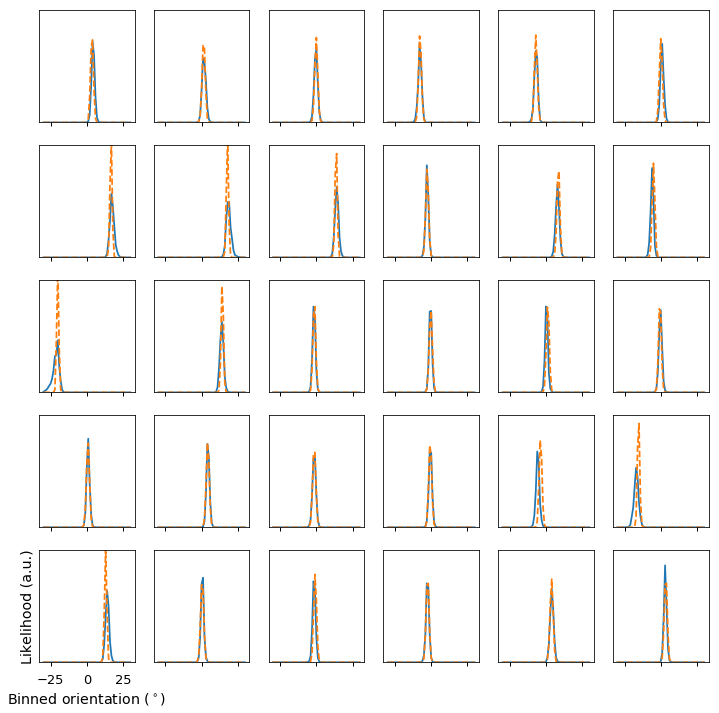

In [64]:
from itertools import count

y = net(valid_x)
#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

gt = np.exp(valid_logl)
gt = gt / gt.sum(axis=1, keepdims=True)


loc = yd.argmax(axis=1)
loc_gt = gt.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta


n_rows = 5
n_cols = 6
fig, axs = plt.subplots(5, 6, figsize=(12, 12))

p = np.random.permutation(len(yd))

for c, ((i, j), ax) in zip(p, np.ndenumerate(axs)):
    
    ax.plot(pv, yd[c])
    ax.plot(pv, gt[c], '--')
    ax.set_ylim([0, 0.5])
    ax.set_yticks([])
    if j == 0 and i == n_rows-1:
        ax.set_ylabel('Likelihood (a.u.)')
        ax.set_xlabel('Binned orientation ($^\circ$)')
    else:
        ax.set_xticklabels([])

#fig.suptitle("Contrast={:0.1f}%  $\mathbf{{E}}[\sigma]$={:0.3f}".format(contrast*100, avg_sigma), fontsize=14)


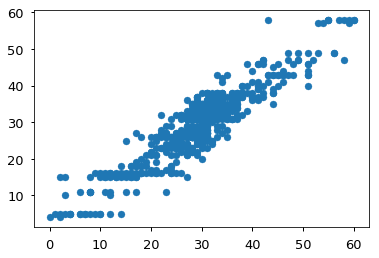

In [515]:
plt.scatter(valid_t, loc)

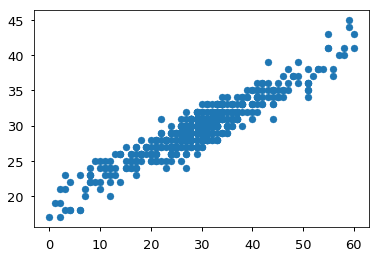

In [516]:
plt.scatter(valid_t, loc_gt)

In [113]:
max(loc_gt)

60

In [ ]:
plt.scat

## Measure std of likelihood functions

In [21]:
loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

np.mean(np.sqrt(np.sum(yd * ds, axis=1)))

8.930213504892635

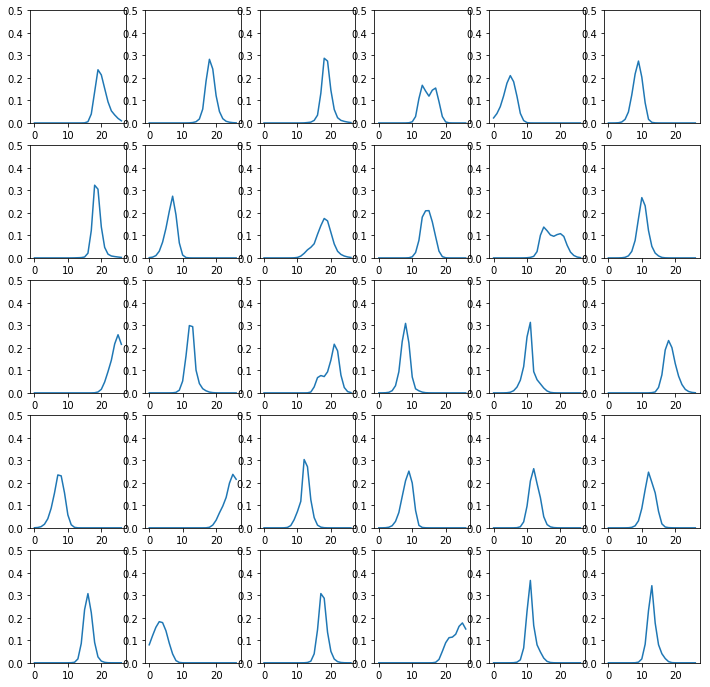

In [44]:
from itertools import count

y = net(valid_x)
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

fig, axs = plt.subplots(5, 6, figsize=(12, 12))
for i, ax in zip(count(), axs.ravel()):
    ax.plot(yd[i])
    ax.set_ylim([0, 0.5])

In [ ]:
data = fetch(class_discrimination.ClassDiscriminationTrial * class_discrimination.SpikeCountTrials * class_discrimination.CSCLookup  & class_discrimination.CleanSpikeCountTrials & self, '*');
            data = dj.struct.sort(data, 'trial_num');
            contrast = fetchn(self, 'dataset_contrast');
            all_contrast = arrayfun(@num2str, [data.contrast], 'UniformOutput', false);
            pos = strcmp(all_contrast, contrast);
            dataSet = data(pos);
            if pack
                dataSet = packData(dataSet);
            end